In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dmt-2024-2nd-assignment/submission_sample.csv
/kaggle/input/dmt-2024-2nd-assignment/test_set_VU_DM.csv
/kaggle/input/dmt-2024-2nd-assignment/training_set_VU_DM.csv


In [36]:
# -*- coding: utf-8 -*-
"""
This is the competition:
https://www.kaggle.com/c/expedia-personalized-sort/discussion

Evaluation NDCG@5
points:

5 - The user purchased a room at this hotel

1 - The user clicked through to see more information on this hotel

0 - The user neither clicked on this hotel nor purchased a room at this hotel
"""
import time
import argparse
import pickle
import os
import gc

import pandas
import numpy as np
import lightgbm
import matplotlib.pylab as plt



def load_data(file_path):
    gc.collect()
    print("Started loading data from file {}".format(file_path))
    orig_data = pandas.read_csv(file_path)
    print("Finished loading data....")
    return orig_data


def add_date_features(
    in_data, datetime_key="date_time", features=["month", "hour", "dayofweek"]
):
    dates = pandas.to_datetime(in_data[datetime_key])
    for feature in features:
        if feature == "month":
            in_data["month"] = dates.dt.month
        elif feature == "dayofweek":
            in_data["dayofweek"] = dates.dt.dayofweek
        elif feature == "hour":
            in_data["hour"] = dates.dt.hour

    return in_data


def normalize_features(input_df, group_key, target_column, take_log10=False):

    # for numerical stability
    epsilon = 1e-4
    if take_log10:
        input_df[target_column] = np.log10(input_df[target_column] + epsilon)
    methods = ["mean", "std"]

    df = input_df.groupby(group_key).agg({target_column: methods})

    df.columns = df.columns.droplevel()
    col = {}
    for method in methods:
        col[method] = target_column + "_" + method

    df.rename(columns=col, inplace=True)
    df_merge = input_df.merge(df.reset_index(), on=group_key)
    df_merge[target_column + "_norm_by_" + group_key] = (
        df_merge[target_column] - df_merge[target_column + "_mean"]
    ) / df_merge[target_column + "_std"]
    df_merge = df_merge.drop(labels=[col["mean"], col["std"]], axis=1)

    gc.collect()
    return df_merge


# Add new columns to the dataframe
def aggregated_features_single_column(
    in_data,
    key_for_grouped_by="prop_id",
    target_column="price_usd",
    agg_methods=["mean", "median", "min", "max"],
    transform_methods={"mean": ["subtract"]},
):
    df = in_data.groupby(key_for_grouped_by).agg({target_column: agg_methods})

    if isinstance(key_for_grouped_by, list):
        str_key_for_grouped_by = "|".join(key_for_grouped_by)
    else:
        str_key_for_grouped_by = key_for_grouped_by

    df.columns = df.columns.droplevel()
    col = {}
    for method in agg_methods:
        col[method] = (
            method.upper() + "(" + str_key_for_grouped_by + ", " + target_column + ")"
        )

    df.rename(columns=col, inplace=True)

    in_data = in_data.merge(df.reset_index(), on=key_for_grouped_by)
    for method_name in transform_methods:
        for applying_function in transform_methods[method_name]:
            function_data = in_data[
                method_name.upper()
                + "("
                + str_key_for_grouped_by
                + ", "
                + target_column
                + ")"
            ]
            column_data = in_data[target_column]
            if applying_function == "substract":
                result = column_data - function_data
            elif applying_function == "divide":
                result = column_data / function_data
            else:
                continue
            in_data[
                applying_function.upper()
                + "("
                + target_column
                + ", "
                + method_name.upper()
                + ")"
            ] = result
    gc.collect()

    return in_data


def drop_columns_with_missing_data(
    df,
    threshold,
    ignore_values=[
        "visitor_hist_adr_usd",
        "visitor_hist_starrating",
        "srch_query_affinity_score",
    ],
):
    columns_to_drop = []

    for i in range(df.shape[1]):
        length_df = len(df)
        column_names = df.columns.tolist()
        number_nans = sum(df.iloc[:, i].isnull())
        if number_nans / length_df > threshold:
            if column_names[i] not in ignore_values:
                columns_to_drop.append(column_names[i])

    print(
        "Dropping columns {} because they miss more than {} of data.".format(
            columns_to_drop, threshold
        )
    )

    df_reduced = df.drop(labels=columns_to_drop, axis=1)
    print("Dropped columns {}".format(columns_to_drop))
    return df_reduced

def sanitize_column_names(df):
    # Replace or remove special JSON characters
    df.columns = [col.replace('{', '').replace('}', '').replace(':', '').replace(',', '')
                  .replace("'", '').replace('"', '') for col in df.columns]
    return df

def preprocess_training_data(orig_data, kind="train", use_ndcg_choices=False):

    print("Preprocessing training data....")
    gc.collect()
    data_for_training = sanitize_column_names(orig_data)  # Sanitize column names
#     data_for_training = orig_data

    target_column = "target"

    if kind == "train":
        conditions = [
            data_for_training["click_bool"] == 1,
            data_for_training["booking_bool"] == 1,
        ]
        choices = [1, 2]
        data_for_training[target_column] = np.select(conditions, choices, default=0)

    threshold = 0.9
    data_for_training = add_date_features(data_for_training)
    data_for_training.drop(labels=["date_time"], axis=1, inplace=True)

    data_for_training = drop_columns_with_missing_data(data_for_training, threshold)

    # do not normalize 2 times with take_log10
    data_for_training = normalize_features(
        data_for_training,
        group_key="srch_id",
        target_column="price_usd",
        take_log10=True,
    )
    data_for_training = normalize_features(
        data_for_training, group_key="prop_id", target_column="price_usd"
    )
    data_for_training = normalize_features(
        data_for_training, group_key="srch_id", target_column="prop_starrating"
    )

#     data_for_training = aggregated_features_single_column(
#         data_for_training, "prop_id", "price_usd", ["mean"]
#     )
#     data_for_training = aggregated_features_single_column(
#         data_for_training,
#         key_for_grouped_by="srch_id",
#         target_column="prop_starrating",
#         agg_methods=["mean"],
#         transform_methods={"mean": ["substract"]},
#     )
#     data_for_training = aggregated_features_single_column(
#         data_for_training,
#         key_for_grouped_by="srch_id",
#         target_column="prop_location_score2",
#         agg_methods=["mean"],
#         transform_methods={"mean": ["substract"]},
#     )
#     data_for_training = aggregated_features_single_column(
#         data_for_training,
#         key_for_grouped_by="srch_id",
#         target_column="prop_location_score1",
#         agg_methods=["mean"],
#         transform_methods={"mean": ["substract"]},
#     )
#     data_for_training = aggregated_features_single_column(
#         data_for_training,
#         key_for_grouped_by="srch_destination_id",
#         target_column="price_usd",
#         agg_methods=["mean"],
#         transform_methods={"mean": ["substract"]},
#     )
#     data_for_training = aggregated_features_single_column(
#         data_for_training,
#         key_for_grouped_by="srch_id",
#         target_column="prop_review_score",
#         agg_methods=["mean"],
#         transform_methods={"mean": ["substract"]},
#     )
#     data_for_training = aggregated_features_single_column(
#         data_for_training,
#         key_for_grouped_by="srch_id",
#         target_column="promotion_flag",
#         agg_methods=["mean"],
#         transform_methods={"mean": ["substract"]},
#     )

    # NOTE: has to be done after aggregated_features_single_column
    data_for_training = data_for_training.sort_values("srch_id")

    data_for_training = normalize_features(
        data_for_training, group_key="srch_id", target_column="prop_starrating"
    )
    data_for_training = normalize_features(
        data_for_training, group_key="srch_id", target_column="prop_location_score2"
    )
    data_for_training = normalize_features(
        data_for_training, group_key="srch_id", target_column="prop_location_score1"
    )
    data_for_training = normalize_features(
        data_for_training, group_key="srch_id", target_column="prop_review_score"
    )

    gc.collect()
    if kind == "train":
        y = data_for_training[target_column].values
    else:
        y = None

    training_set_only_metrics = ["click_bool", "booking_bool", "gross_bookings_usd"]
    columns_to_remove = [
        "date_time",
        "target",
        target_column,
    ] + training_set_only_metrics
    columns_to_remove = [
        c for c in columns_to_remove if c in data_for_training.columns.values
    ]
    data_for_training = data_for_training.drop(labels=columns_to_remove, axis=1)
    return data_for_training, y


def remove_columns(x1, ignore_column=["srch_id", "prop_id", "position", "random_bool"]):
    ignore_column = [c for c in ignore_column if c in x1.columns.values]
    # print('Dropping columns: {}'.format(ignore_column))
    # ignore_column_numbers = [x1.columns.get_loc(x) for x in ignore_column]
    x1 = x1.drop(labels=ignore_column, axis=1)
    # print('Columns after dropping: {}'.format(x1.columns.values))
    return x1


def input_estimated_position(training_data, srch_id_dest_id_dict):
    training_data = training_data.merge(
        srch_id_dest_id_dict, how="left", on=["srch_destination_id", "prop_id"]
    )
    print(training_data.head())
    return training_data


def split_train_data(data_for_training, y, val_start=0, val_end=0):

    x1 = pandas.concat([data_for_training[0:val_start], data_for_training[val_end:]])
    y1 = np.concatenate((y[0:val_start], y[val_end:]), axis=0)
    x2 = data_for_training[val_start:val_end]
    y2 = y[val_start:val_end]

    srch_id_dest_id_dict = x1.loc[x1["random_bool"] == 0]

    # estimated position calculation
    srch_id_dest_id_dict = x1.loc[x1["random_bool"] == 0]
    srch_id_dest_id_dict = x1.groupby(["srch_destination_id", "prop_id"]).agg(
        {"position": "mean"}
    )
    srch_id_dest_id_dict = srch_id_dest_id_dict.rename(
        index=str, columns={"position": "estimated_position"}
    ).reset_index()
    srch_id_dest_id_dict["srch_destination_id"] = (
        srch_id_dest_id_dict["srch_destination_id"].astype(str).astype(int)
    )
    srch_id_dest_id_dict["prop_id"] = (
        srch_id_dest_id_dict["prop_id"].astype(str).astype(int)
    )
    srch_id_dest_id_dict["estimated_position"] = (
        1 / srch_id_dest_id_dict["estimated_position"]
    )
    x1 = input_estimated_position(x1, srch_id_dest_id_dict)
    x2 = input_estimated_position(x2, srch_id_dest_id_dict)

    groups = x1["srch_id"].value_counts(sort=False).sort_index()
    eval_groups = x2["srch_id"].value_counts(sort=False).sort_index()
    len(eval_groups), len(x2), len(x1), len(groups)

    x1 = remove_columns(x1)
    x2 = remove_columns(x2)
    return (x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict)


def get_categorical_column(x1):
    categorical_features = [
        "day",
        "month",
        "prop_country_id",
        "site_id",
        "visitor_location_country_id",
    ]
    categorical_features = [c for c in categorical_features if c in x1.columns.values]
    categorical_features_numbers = [x1.columns.get_loc(x) for x in categorical_features]
    return categorical_features_numbers


def train_model(
    x1, x2, y1, y2, groups, eval_groups, lr, method, output_dir, name_of_model=None
):
    if not name_of_model:
        name_of_model = str(int(time.time()))

    categorical_features_numbers = get_categorical_column(x1)
    clf = lightgbm.LGBMRanker(
        objective="lambdarank",
        metric="ndcg",
        n_estimators=1000,
        learning_rate=lr,
        max_position=5,
        label_gain=[0, 1, 2],
        random_state=69,
        seed=69,
        boosting=method,
    )
    gc.collect()

    early_stopping_callback = early_stopping(stopping_rounds=200, verbose=True)
    log_evaluation_callback = log_evaluation(period=50)

    print("Training on train set with columns: {}".format(x1.columns.values))
    clf.fit(
        x1,
        y1,
        eval_set=[(x1, y1), (x2, y2)],
        eval_group=[groups, eval_groups],
        group=groups,
        eval_at=5,
#         verbose=20,
#         early_stopping_rounds=200,
        callbacks=[early_stopping_callback,log_evaluation_callback],
        categorical_feature=categorical_features_numbers,
    )
    gc.collect()
    pickle.dump(clf, open(os.path.join(output_dir, "model.dat"), "wb"))
    
    return clf


def predict(name_of_model, test_data, srch_id_dest_id_dict, output_dir):

    gc.collect()

    model = pickle.load(open(os.path.join(output_dir, "model.dat"), "rb"))

    test_data = test_data.copy()
    test_data = input_estimated_position(test_data, srch_id_dest_id_dict)

    test_data_srch_id_prop_id = test_data[["srch_id", "prop_id"]]

    test_data = remove_columns(test_data)

    categorical_features_numbers = get_categorical_column(test_data)

    print("Predicting on train set with columns: {}".format(test_data.columns.values))
    kwargs = {}
    kwargs = {"categorical_feature": categorical_features_numbers}

    predictions = model.predict(test_data, **kwargs)
    test_data_srch_id_prop_id["prediction"] = predictions
    del test_data
    gc.collect()

    test_data_srch_id_prop_id = test_data_srch_id_prop_id.sort_values(
        ["srch_id", "prediction"], ascending=[True, False]
    )
    print("Saving predictions into submission.csv")
    test_data_srch_id_prop_id[["srch_id", "prop_id"]].to_csv(
        os.path.join(output_dir, "submission.csv"), index=False
    )




In [37]:
train_csv = '/kaggle/input/dmt-2024-2nd-assignment/training_set_VU_DM.csv'
test_csv = '/kaggle/input/dmt-2024-2nd-assignment/test_set_VU_DM.csv'
output_dir = '/kaggle/working/'

name_of_model = str(int(time.time()))

training_data = load_data(train_csv)
training_data, y = preprocess_training_data(training_data)

Started loading data from file /kaggle/input/dmt-2024-2nd-assignment/training_set_VU_DM.csv
Finished loading data....
Preprocessing training data....
Dropping columns ['comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'gross_bookings_usd'] because they miss more than 0.9 of data.
Dropped columns ['comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'gross_bookings_usd']


In [38]:
import pandas as pd

# Function to make column names JSON compliant
def make_column_names_json_compliant(df):
    df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)
    return df

# Apply the function to the DataFrame
training_data = make_column_names_json_compliant(training_data)

# Print the new column names
print(training_data.columns)
print(training_data.shape)

Index(['srch_id', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'comp5_rate',
       'comp5_inv', 'comp5_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff', 'month', 'hour', 'dayofweek',
       'price_usd_norm_by_srch_id', 'price_usd_norm_by_prop_id',
       'prop_starrating_norm_by_srch_id',
       'prop_location_score2_norm_by_srch_id

In [39]:
from lightgbm import early_stopping, log_evaluation

In [40]:
method = "goss"
validation_num = 150000
lr = 0.12 
# for i in range(0, int(len(training_data.index) / validation_num)): # enable for cross-validation
for i in range(0, 1):
    val_start = i * validation_num
    val_end = (i + 1) * validation_num
    x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict = split_train_data(
        training_data, y, val_start, val_end
    )
    model = train_model(
        x1, x2, y1, y2, groups, eval_groups, lr, method, output_dir, name_of_model
    )
    test_data = load_data(test_csv)
    test_data, _ = preprocess_training_data(test_data, kind="test")
    test_data = make_column_names_json_compliant(test_data)
    predict(name_of_model, test_data, srch_id_dest_id_dict, output_dir)
    print("Submit the predictions file submission.csv to kaggle")


   srch_id  site_id  visitor_location_country_id  visitor_hist_starrating  \
0    10053        5                          219                      NaN   
1    10053        5                          219                      NaN   
2    10053        5                          219                      NaN   
3    10053        5                          219                      NaN   
4    10053        5                          219                      NaN   

   visitor_hist_adr_usd  prop_country_id  prop_id  prop_starrating  \
0                   NaN              219    26711                2   
1                   NaN              219    28940                3   
2                   NaN              219    34016                3   
3                   NaN              219    37818                4   
4                   NaN              219    38124                2   

   prop_review_score  prop_brand_bool  ...  month  hour  dayofweek  \
0                0.0                1  ...    

Started loading data from file /kaggle/input/dmt-2024-2nd-assignment/test_set_VU_DM.csv
Finished loading data....
Preprocessing training data....
Dropping columns ['comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff'] because they miss more than 0.9 of data.
Dropped columns ['comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff']
   srch_id  site_id  visitor_location_country_id  visitor_hist_starrating  \
0        1       24                          216                      NaN   
1        1       24                          216                      NaN   
2        1       24                          216             

<Figure size 640x480 with 0 Axes>

In [41]:
def predict(name_of_model, test_data, srch_id_dest_id_dict, output_dir):

    gc.collect()

    model = pickle.load(open(os.path.join(output_dir, "model.dat"), "rb"))

    test_data = test_data.copy()
    test_data = input_estimated_position(test_data, srch_id_dest_id_dict)

    test_data_srch_id_prop_id = test_data[["srch_id", "prop_id"]]

    test_data = remove_columns(test_data)

    categorical_features_numbers = get_categorical_column(test_data)

    print("Predicting on train set with columns: {}".format(test_data.columns.values))
    kwargs = {}
    kwargs = {"categorical_feature": categorical_features_numbers}

    predictions = model.predict(test_data, **kwargs)
    test_data_srch_id_prop_id["prediction"] = predictions
    del test_data
    gc.collect()

    test_data_srch_id_prop_id = test_data_srch_id_prop_id.sort_values(
        ["srch_id", "prediction"], ascending=[True, False]
    )
    print("Saving predictions into submission.csv")
    test_data_srch_id_prop_id[["srch_id", "prop_id"]].to_csv(
        os.path.join(output_dir, "submission.csv"), index=False
    )


In [42]:
method = "goss"
validation_num = 150000
lr = 0.12 
# for i in range(0, int(len(training_data.index) / validation_num)): # enable for cross-validation
for i in range(0, 1):
#     val_start = i * validation_num
#     val_end = (i + 1) * validation_num
#     x1, x2, y1, y2, groups, eval_groups, srch_id_dest_id_dict = split_train_data(
#         training_data, y, val_start, val_end
#     )
#     model = train_model(
#         x1, x2, y1, y2, groups, eval_groups, lr, method, output_dir, name_of_model
#     )
    test_data = load_data(test_csv)
    test_data, _ = preprocess_training_data(test_data, kind="test")
    test_data = make_column_names_json_compliant(test_data)
    predict(name_of_model, test_data, srch_id_dest_id_dict, output_dir)
    print("Submit the predictions file submission.csv to kaggle")

Started loading data from file /kaggle/input/dmt-2024-2nd-assignment/test_set_VU_DM.csv
Finished loading data....
Preprocessing training data....
Dropping columns ['comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff'] because they miss more than 0.9 of data.
Dropped columns ['comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff']
   srch_id  site_id  visitor_location_country_id  visitor_hist_starrating  \
0        1       24                          216                      NaN   
1        1       24                          216                      NaN   
2        1       24                          216             

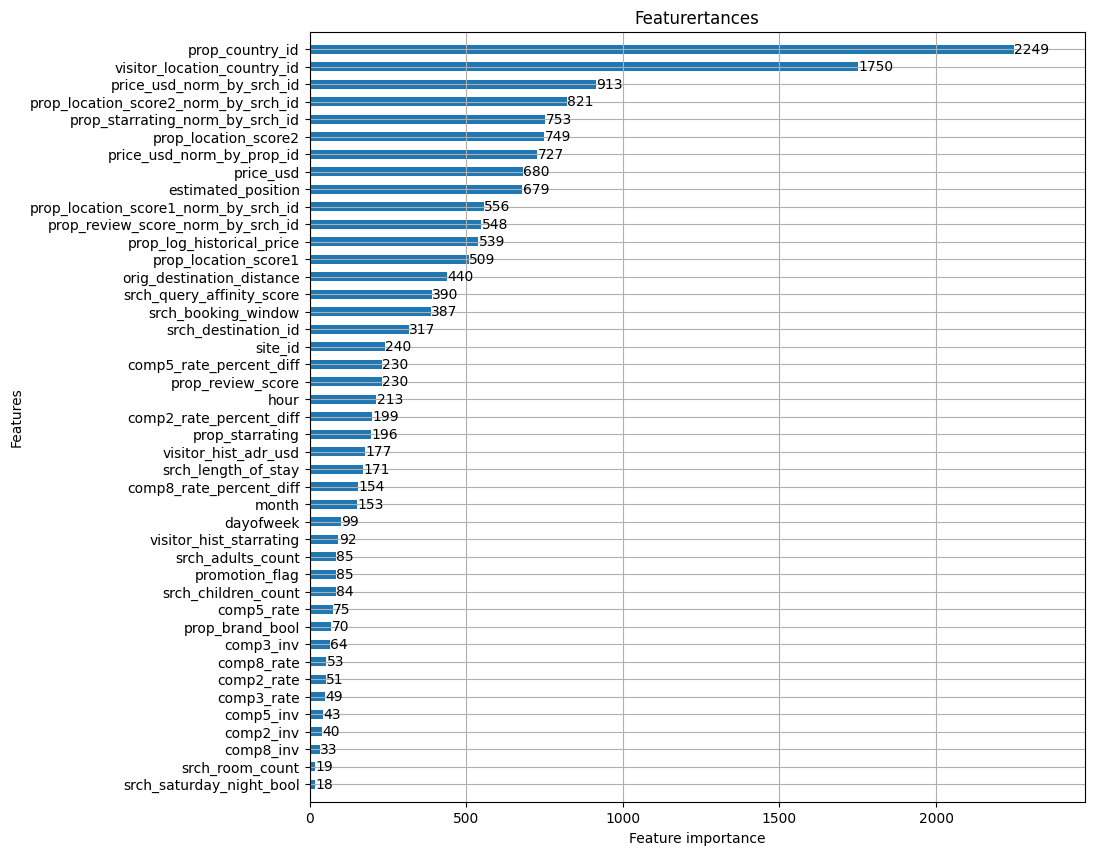

In [49]:
# =========================================================================
model = pickle.load(open(os.path.join(output_dir, "model.dat"), "rb"))
fig,ax = plt.subplots(figsize=(10,10))
lightgbm.plot_importance(model,height=0.5,ax=ax,max_num_features=50)
plt.title("Featurertances")
plt.show()